In [7]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from keras.utils import to_categorical
from keras.models import load_model
from keras.models import Model
from keras.layers import *

import segmentation_models as sm
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import cv2
import os

### Exploratory Data Analysis

(np.float64(-0.5), np.float64(3023.5), np.float64(3023.5), np.float64(-0.5))

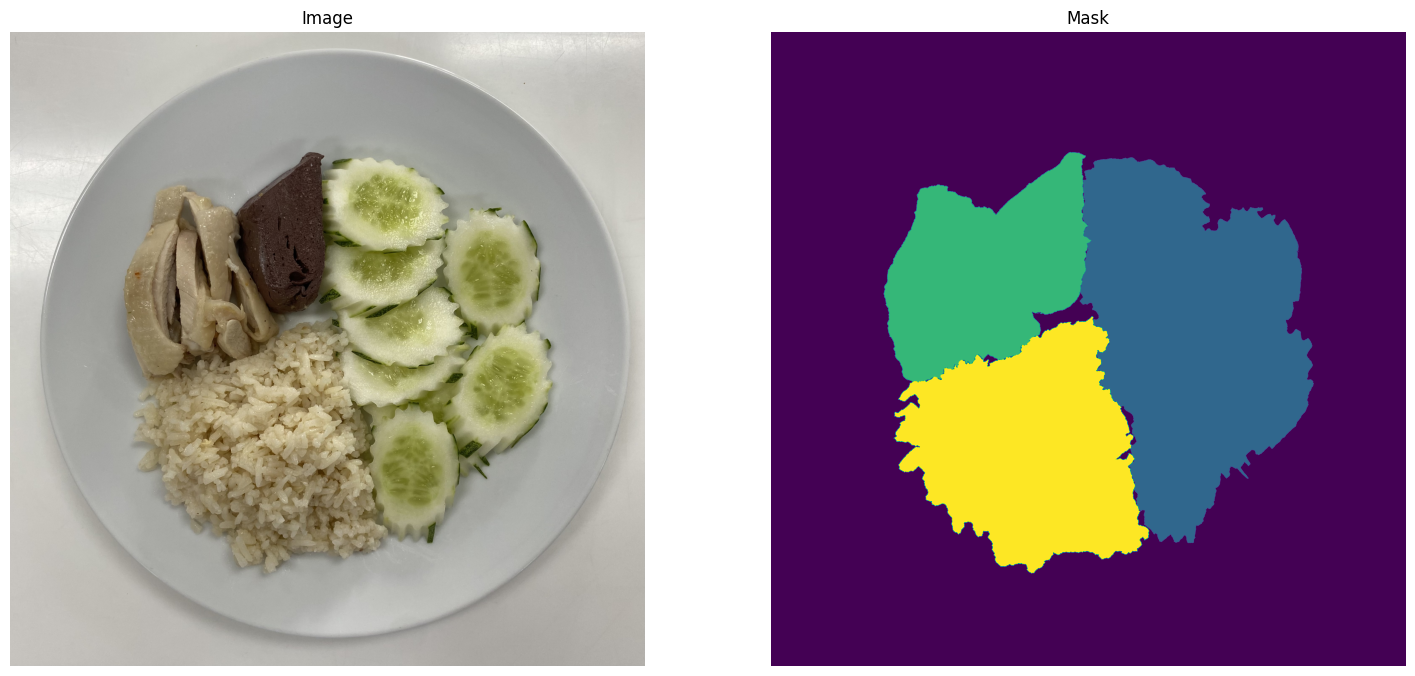

In [8]:
index = input('Image index: ')
if len(index) == 1:
    index = '0' + str(index)
example_img = cv2.imread(f'../Data/Images/3/I0{index}/0{index}-1.jpg', 1)
example_mask = cv2.imread(f'../Data/Masks/3/L0{index}/L0{index}-1.png', 0)

plt.figure(figsize=(18, 12))

plt.subplot(121)
plt.imshow(cv2.cvtColor(example_img, cv2.COLOR_BGR2RGB))
plt.title('Image')
plt.axis('off')

plt.subplot(122)
plt.imshow(example_mask)
plt.title('Mask')
plt.axis('off')

In [9]:
def calculateProportion(mask):
    segment_areas = {}
    segment = [1, 2, 3]
    categories = ['Vegetable', 'Protein', 'Carbohydrate']

    for label in np.unique(mask):
        area = np.sum(mask == label)
        segment_areas[label] = area

    
    segment_areas = {key: segment_areas[key] for key in segment}

    total_area = sum(segment_areas.values())

    for label, area in segment_areas.items():
        proportion = area / total_area
        print(f'{categories[label-1]} Proportion = {proportion:.4f}')

In [10]:
calculateProportion(example_mask)

Vegetable Proportion = 0.4514
Protein Proportion = 0.2313
Carbohydrate Proportion = 0.3173


### Load Data

In [11]:
def loadImageAndMask():
    X_size = 128
    y_size = 128
    X_train = []
    X_val = []
    X_test = []
    y_train = []
    y_val = []
    y_test = []
    for i in range(0, len([f for f in os.listdir(f'../Data/Images/3') if f != '.DS_Store'])):
        index = i + 1
        if len(str(index)) == 1:
            index = '0' + str(index)
        else:
            index = str(index)

        for j in range(len([f for f in os.listdir(f'../Data/Images/3/I0{index}') if f != '.DS_Store'])):
            img = cv2.imread(f'../Data/Images/3/I0{index}/0{index}-{j+1}.jpg', 1)
            mask = cv2.imread(f'../Data/Masks/3/L0{index}/L0{index}-{j+1}.png', 0)
            img = cv2.resize(img, (y_size, X_size))
            mask = cv2.resize(mask, (y_size, X_size))
            
            if i <= len([f for f in os.listdir(f'../Data/Images/3/') if f != '.DS_Store']) - 3:
                X_train.append(img)
                y_train.append(mask)
            elif i <= len([f for f in os.listdir(f'../Data/Images/3/') if f != '.DS_Store']) - 2:
                X_val.append(img)
                y_val.append(mask)
            else:
                X_test.append(img)
                y_test.append(mask)
            
    X_train = np.array(X_train)
    X_train = X_train / 255
    X_val = np.array(X_val)
    X_val = X_val / 255
    X_test = np.array(X_test)
    X_test = X_test / 255
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    y_test = np.array(y_test)
    return X_train, X_val, X_test, y_train, y_val, y_test 


In [12]:
X_train, X_val, X_test, y_train, y_val, y_test = loadImageAndMask()
print(f'Image array shape: {X_train.shape} --> Type: {type(X_train)}')
print(f'Image array shape: {X_val.shape} --> Type: {type(X_test)}')
print(f'Image array shape: {X_test.shape} --> Type: {type(X_test)}')
print(f'Mask array shape: {y_train.shape} --> Type: {type(y_train)}')
print(f'Mask array shape: {y_val.shape} --> Type: {type(y_test)}')
print(f'Mask array shape: {y_test.shape} --> Type: {type(y_test)}')

Image array shape: (210, 128, 128, 3) --> Type: <class 'numpy.ndarray'>
Image array shape: (15, 128, 128, 3) --> Type: <class 'numpy.ndarray'>
Image array shape: (15, 128, 128, 3) --> Type: <class 'numpy.ndarray'>
Mask array shape: (210, 128, 128) --> Type: <class 'numpy.ndarray'>
Mask array shape: (15, 128, 128) --> Type: <class 'numpy.ndarray'>
Mask array shape: (15, 128, 128) --> Type: <class 'numpy.ndarray'>


### Pre-Processing Data

In [13]:
np.unique(y_train)

array([0, 1, 2, 3], dtype=uint8)

In [14]:
n_classes = 4

def labelEncoder(masks):
    labelencoder = LabelEncoder()
    n, h, w = masks.shape
    mask_reshaped = masks.reshape(-1, 1)
    mask_reshaped_encoded = labelencoder.fit_transform(mask_reshaped)
    class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(mask_reshaped_encoded), y=mask_reshaped_encoded)
    mask_categorized = mask_reshaped_encoded.reshape(n, h, w)
    return mask_categorized, class_weights

In [15]:
y_train, class_weights = labelEncoder(y_train)
y_val, _ = labelEncoder(y_val)
y_test, _ = labelEncoder(y_test)

print(np.unique(y_train))
print(class_weights)

/Users/patinya_jaruariyanon/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[0 1 2 3]
[0.37299676 3.02092479 2.40250708 1.7490001 ]


/Users/patinya_jaruariyanon/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/patinya_jaruariyanon/Library/Python/3.9/lib/python/site-packages/sklearn/preprocessing/_label.py:110: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [16]:
y_train = np.expand_dims(y_train, axis=3)
y_val = np.expand_dims(y_val, axis=3)
y_test = np.expand_dims(y_test, axis=3)

In [17]:
def oneHotEncoder(masks):
    mask_categorical = to_categorical(masks, num_classes=n_classes)
    mask_categorized = mask_categorical.reshape(masks.shape[0], masks.shape[1], masks.shape[2], n_classes)
    return mask_categorized

In [18]:
y_train = oneHotEncoder(y_train)
y_val = oneHotEncoder(y_val)
y_test = oneHotEncoder(y_test)

Categorical Shape: (210, 128, 128, 4)

['Other', 'Vegetable', 'Protein', 'Carbohydrate']
First Pixel Categorized: [1. 0. 0. 0.]
Middle Pixel Categorized: [0. 0. 0. 1.]


(np.float64(-0.5), np.float64(3023.5), np.float64(3023.5), np.float64(-0.5))

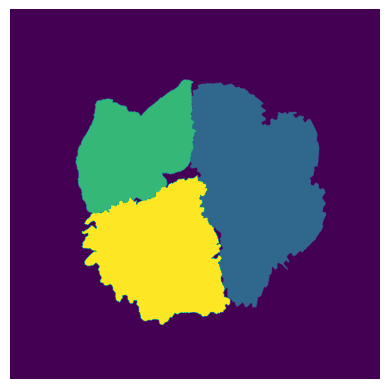

In [19]:
print(f'Categorical Shape: {y_train.shape}\n')
print("['Other', 'Vegetable', 'Protein', 'Carbohydrate']")
print(f'First Pixel Categorized: {y_train[0][0][0]}')
print(f'Middle Pixel Categorized: {y_train[11][64][64]}')
plt.imshow(example_mask)
plt.axis('off')

In [20]:
print(f'X_train Shape: {X_train.shape}')
print(f'X_test Shape: {X_test.shape}')
print(f'y_train Shape: {y_train.shape}')
print(f'y_test Shape: {y_test.shape}')

X_train Shape: (210, 128, 128, 3)
X_test Shape: (15, 128, 128, 3)
y_train Shape: (210, 128, 128, 4)
y_test Shape: (15, 128, 128, 4)


### Modeling

In [21]:
n_classes = 4
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

In [22]:
def unet_vgg16(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
   
    c1 = Conv2D(64, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(inputs)
    c1 = Conv2D(64, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c1)
    p1 = MaxPool2D(2)(c1)
    p1 = Dropout(0.3)(p1)

    c2 = Conv2D(128, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(p1)
    c2 = Conv2D(128, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c2)
    p2 = MaxPool2D(2)(c2)
    p2 = Dropout(0.3)(p2)

    c3 = Conv2D(256, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(p2)
    c3 = Conv2D(256, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c3)
    c3 = Conv2D(256, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c3)
    p3 = MaxPool2D(2)(c3)
    p3 = Dropout(0.3)(p3)

    c4 = Conv2D(512, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(p3)
    c4 = Conv2D(512, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c4)
    c4 = Conv2D(512, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c4)
    p4 = MaxPool2D(2)(c4)
    p4 = Dropout(0.3)(p4)

    c5 = Conv2D(512, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(p4)
    c5 = Conv2D(512, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c5)
    c5 = Conv2D(512, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c5)

    c6 = Conv2DTranspose(512, 3, 2, padding = "same")(c5)
    c6 = concatenate([c6, c4])
    c6 = Dropout(0.3)(c6)
    c6 = Conv2D(512, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c6)
    c6 = Conv2D(512, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c6)
    c6 = Conv2D(512, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c6)

    c7 = Conv2DTranspose(256, 3, 2, padding = "same")(c6)
    c7 = concatenate([c7, c3])
    c7 = Dropout(0.3)(c7)
    c7 = Conv2D(256, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c7)
    c7 = Conv2D(256, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c7)
    c7 = Conv2D(256, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c7)
    
    c8 = Conv2DTranspose(128, 3, 2, padding = "same")(c7)
    c8 = concatenate([c8, c2])
    c8 = Dropout(0.3)(c8)
    c8 = Conv2D(128, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c8)
    c8 = Conv2D(128, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c8)

    c9 = Conv2DTranspose(64, 3, 2, padding = "same")(c8)
    c9 = concatenate([c9, c1])
    c9 = Dropout(0.3)(c9)
    c9 = Conv2D(64, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c9)
    c9 = Conv2D(64, 3, padding = "same", activation = "relu", kernel_initializer = "he_normal")(c9)

    outputs = Conv2D(n_classes, 1, padding = "same", activation = "softmax")(c9)

    unet_model = Model(inputs, outputs)

    return unet_model

In [23]:
model = unet_vgg16(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

In [24]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ conv2d_2[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ conv2d_3[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_4[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 32, 32,    │    590,080 │ conv2d_5[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 16, 16,    │          0 │ max_pooling2d_2[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 16, 16,    │  1,180,160 │ dropout_2[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_7[0][0]    │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 16, 16,    │  2,359,808 │ conv2d_8[0][0]  

 Total params: 30,975,620 (118.16 MB)

 Trainable params: 30,975,620 (118.16 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
dice_loss = sm.losses.DiceLoss(class_weights=np.array(class_weights)) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = sm.metrics.IOUScore(threshold=0.5)

model.compile(optimizer='adam', loss=total_loss, metrics=[metrics])

In [26]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(filepath='checkpoint/model_checkpoint.h5', save_best_only=True),
    tf.keras.callbacks.EarlyStopping(monitor='val_iou_score', patience=40, mode='max', restore_best_weights=True)
]

In [27]:
history = model.fit(X_train, y_train, batch_size=X_train.shape[0], verbose=1, epochs=500, validation_data=(X_val, y_val), callbacks=callbacks)

Epoch 1/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61s/step - iou_score: 0.0130 - loss: 0.7876

1/1 ━━━━━━━━━━━━━━━━━━━━ 63s 63s/step - iou_score: 0.0130 - loss: 0.7876 - val_iou_score: 0.1357 - val_loss: 0.8213
Epoch 2/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57s/step - iou_score: 0.1611 - loss: 0.9548

1/1 ━━━━━━━━━━━━━━━━━━━━ 58s 58s/step - iou_score: 0.1611 - loss: 0.9548 - val_iou_score: 5.6623e-05 - val_loss: 0.7523
Epoch 3/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 56s 56s/step - iou_score: 0.0198 - loss: 0.7366 - val_iou_score: 1.3028e-05 - val_loss: 0.7575
Epoch 4/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53s/step - iou_score: 0.0033 - loss: 0.7269

1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - iou_score: 0.0033 - loss: 0.7269 - val_iou_score: 2.6381e-04 - val_loss: 0.7493
Epoch 5/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52s/step - iou_score: 0.0108 - loss: 0.7105

1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - iou_score: 0.0108 - loss: 0.7105 - val_iou_score: 0.0401 - val_loss: 0.7269
Epoch 6/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 55s 55s/step - iou_score: 0.0629 - loss: 0.7203 - val_iou_score: 0.1800 - val_loss: 0.7319
Epoch 7/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52s/step - iou_score: 0.1820 - loss: 0.6726

1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.1820 - loss: 0.6726 - val_iou_score: 0.1710 - val_loss: 0.7252
Epoch 8/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53s/step - iou_score: 0.1837 - loss: 0.6530

1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - iou_score: 0.1837 - loss: 0.6530 - val_iou_score: 0.1794 - val_loss: 0.7033
Epoch 9/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54s/step - iou_score: 0.1900 - loss: 0.6175

1/1 ━━━━━━━━━━━━━━━━━━━━ 56s 56s/step - iou_score: 0.1900 - loss: 0.6175 - val_iou_score: 0.1935 - val_loss: 0.6892
Epoch 10/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56s/step - iou_score: 0.2057 - loss: 0.5844

1/1 ━━━━━━━━━━━━━━━━━━━━ 58s 58s/step - iou_score: 0.2057 - loss: 0.5844 - val_iou_score: 0.2181 - val_loss: 0.6667
Epoch 11/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54s/step - iou_score: 0.2333 - loss: 0.5445

1/1 ━━━━━━━━━━━━━━━━━━━━ 55s 55s/step - iou_score: 0.2333 - loss: 0.5445 - val_iou_score: 0.1990 - val_loss: 0.6265
Epoch 12/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53s/step - iou_score: 0.2239 - loss: 0.4981

1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - iou_score: 0.2239 - loss: 0.4981 - val_iou_score: 0.2005 - val_loss: 0.5913
Epoch 13/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52s/step - iou_score: 0.2322 - loss: 0.4561

1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - iou_score: 0.2322 - loss: 0.4561 - val_iou_score: 0.2544 - val_loss: 0.5702
Epoch 14/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54s/step - iou_score: 0.3071 - loss: 0.4038

1/1 ━━━━━━━━━━━━━━━━━━━━ 56s 56s/step - iou_score: 0.3071 - loss: 0.4038 - val_iou_score: 0.2649 - val_loss: 0.5232
Epoch 15/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53s/step - iou_score: 0.3343 - loss: 0.3344

1/1 ━━━━━━━━━━━━━━━━━━━━ 55s 55s/step - iou_score: 0.3343 - loss: 0.3344 - val_iou_score: 0.3329 - val_loss: 0.4514
Epoch 16/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 55s 55s/step - iou_score: 0.3874 - loss: 0.2701 - val_iou_score: 0.2876 - val_loss: 0.6064
Epoch 17/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - iou_score: 0.3365 - loss: 0.3541 - val_iou_score: 0.3341 - val_loss: 0.4554
Epoch 18/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52s/step - iou_score: 0.3894 - loss: 0.2916

1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.3894 - loss: 0.2916 - val_iou_score: 0.3823 - val_loss: 0.3483
Epoch 19/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.4490 - loss: 0.1508 - val_iou_score: 0.3051 - val_loss: 0.5347
Epoch 20/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 63s 63s/step - iou_score: 0.3812 - loss: 0.2437 - val_iou_score: 0.3592 - val_loss: 0.4019
Epoch 21/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 56s 56s/step - iou_score: 0.4587 - loss: 0.0940 - val_iou_score: 0.3126 - val_loss: 0.3595
Epoch 22/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50s/step - iou_score: 0.4209 - loss: 0.1190

1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - iou_score: 0.4209 - loss: 0.1190 - val_iou_score: 0.3356 - val_loss: 0.3206
Epoch 23/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52s/step - iou_score: 0.4495 - loss: 0.0817

1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.4495 - loss: 0.0817 - val_iou_score: 0.5257 - val_loss: 0.1808
Epoch 24/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - iou_score: 0.5678 - loss: -0.0619 - val_iou_score: 0.3786 - val_loss: 0.3332
Epoch 25/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53s/step - iou_score: 0.4899 - loss: 0.0313

1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - iou_score: 0.4899 - loss: 0.0313 - val_iou_score: 0.5733 - val_loss: 0.0777
Epoch 26/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - iou_score: 0.6071 - loss: -0.1397 - val_iou_score: 0.4434 - val_loss: 0.1766
Epoch 27/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57s/step - iou_score: 0.5320 - loss: -0.0889

1/1 ━━━━━━━━━━━━━━━━━━━━ 58s 58s/step - iou_score: 0.5320 - loss: -0.0889 - val_iou_score: 0.5043 - val_loss: 0.0736
Epoch 28/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55s/step - iou_score: 0.5746 - loss: -0.1671

1/1 ━━━━━━━━━━━━━━━━━━━━ 56s 56s/step - iou_score: 0.5746 - loss: -0.1671 - val_iou_score: 0.5964 - val_loss: 0.0586
Epoch 29/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58s/step - iou_score: 0.6285 - loss: -0.1948

1/1 ━━━━━━━━━━━━━━━━━━━━ 60s 60s/step - iou_score: 0.6285 - loss: -0.1948 - val_iou_score: 0.6419 - val_loss: -0.0977
Epoch 30/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 55s 55s/step - iou_score: 0.6726 - loss: -0.2856 - val_iou_score: 0.5788 - val_loss: -0.0625
Epoch 31/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55s/step - iou_score: 0.6225 - loss: -0.2595

1/1 ━━━━━━━━━━━━━━━━━━━━ 56s 56s/step - iou_score: 0.6225 - loss: -0.2595 - val_iou_score: 0.6353 - val_loss: -0.1883
Epoch 32/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.6803 - loss: -0.3445 - val_iou_score: 0.5811 - val_loss: -0.0533
Epoch 33/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 55s 55s/step - iou_score: 0.6387 - loss: -0.2836 - val_iou_score: 0.5924 - val_loss: -0.1288
Epoch 34/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52s/step - iou_score: 0.6198 - loss: -0.2777

1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.6198 - loss: -0.2777 - val_iou_score: 0.6283 - val_loss: -0.2211
Epoch 35/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 58s 58s/step - iou_score: 0.6789 - loss: -0.3681 - val_iou_score: 0.6064 - val_loss: -0.1615
Epoch 36/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54s/step - iou_score: 0.6544 - loss: -0.3326

1/1 ━━━━━━━━━━━━━━━━━━━━ 55s 55s/step - iou_score: 0.6544 - loss: -0.3326 - val_iou_score: 0.6429 - val_loss: -0.2799
Epoch 37/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.6819 - loss: -0.3861 - val_iou_score: 0.6399 - val_loss: -0.2722
Epoch 38/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.6542 - loss: -0.3469 - val_iou_score: 0.6575 - val_loss: -0.2766
Epoch 39/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54s/step - iou_score: 0.6833 - loss: -0.3886

1/1 ━━━━━━━━━━━━━━━━━━━━ 55s 55s/step - iou_score: 0.6833 - loss: -0.3886 - val_iou_score: 0.6830 - val_loss: -0.3316
Epoch 40/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56s/step - iou_score: 0.7023 - loss: -0.4066

1/1 ━━━━━━━━━━━━━━━━━━━━ 57s 57s/step - iou_score: 0.7023 - loss: -0.4066 - val_iou_score: 0.6927 - val_loss: -0.3442
Epoch 41/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58s/step - iou_score: 0.7127 - loss: -0.4312

1/1 ━━━━━━━━━━━━━━━━━━━━ 59s 59s/step - iou_score: 0.7127 - loss: -0.4312 - val_iou_score: 0.6779 - val_loss: -0.3534
Epoch 42/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52s/step - iou_score: 0.7023 - loss: -0.4295

1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.7023 - loss: -0.4295 - val_iou_score: 0.6920 - val_loss: -0.3855
Epoch 43/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 55s 55s/step - iou_score: 0.7163 - loss: -0.4527 - val_iou_score: 0.6758 - val_loss: -0.3507
Epoch 44/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 56s 56s/step - iou_score: 0.6918 - loss: -0.4168 - val_iou_score: 0.6853 - val_loss: -0.3723
Epoch 45/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55s/step - iou_score: 0.7015 - loss: -0.4270

1/1 ━━━━━━━━━━━━━━━━━━━━ 56s 56s/step - iou_score: 0.7015 - loss: -0.4270 - val_iou_score: 0.7391 - val_loss: -0.4532
Epoch 46/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 56s 56s/step - iou_score: 0.7375 - loss: -0.4844 - val_iou_score: 0.7341 - val_loss: -0.4335
Epoch 47/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.7286 - loss: -0.4655 - val_iou_score: 0.6887 - val_loss: -0.3842
Epoch 48/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55s/step - iou_score: 0.7011 - loss: -0.4282

1/1 ━━━━━━━━━━━━━━━━━━━━ 56s 56s/step - iou_score: 0.7011 - loss: -0.4282 - val_iou_score: 0.7584 - val_loss: -0.4900
Epoch 49/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51s/step - iou_score: 0.7458 - loss: -0.5006

1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.7458 - loss: -0.5006 - val_iou_score: 0.7540 - val_loss: -0.4910
Epoch 50/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 56s 56s/step - iou_score: 0.7350 - loss: -0.4859 - val_iou_score: 0.6743 - val_loss: -0.3344
Epoch 51/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 55s 55s/step - iou_score: 0.6837 - loss: -0.3911 - val_iou_score: 0.7072 - val_loss: -0.4062
Epoch 52/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 55s 55s/step - iou_score: 0.6978 - loss: -0.4275 - val_iou_score: 0.7281 - val_loss: -0.4504
Epoch 53/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - iou_score: 0.7388 - loss: -0.4963 - val_iou_score: 0.7021 - val_loss: -0.4088
Epoch 54/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - iou_score: 0.7235 - loss: -0.4726 - val_iou_score: 0.7323 - val_loss: -0.4398
Epoch 55/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53s/step - iou_score: 0.7369 - loss: -0.4872

1/1 ━━━━━━━━━━━━━━━━━━━━ 55s 55s/step - iou_score: 0.7369 - loss: -0.4872 - val_iou_score: 0.7628 - val_loss: -0.5095
Epoch 56/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - iou_score: 0.7574 - loss: -0.5260 - val_iou_score: 0.7445 - val_loss: -0.4852
Epoch 57/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55s/step - iou_score: 0.7458 - loss: -0.5070

1/1 ━━━━━━━━━━━━━━━━━━━━ 57s 57s/step - iou_score: 0.7458 - loss: -0.5070 - val_iou_score: 0.7739 - val_loss: -0.5361
Epoch 58/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52s/step - iou_score: 0.7564 - loss: -0.5247

1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - iou_score: 0.7564 - loss: -0.5247 - val_iou_score: 0.7780 - val_loss: -0.5422
Epoch 59/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - iou_score: 0.7560 - loss: -0.5239 - val_iou_score: 0.7602 - val_loss: -0.5072
Epoch 60/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50s/step - iou_score: 0.7500 - loss: -0.5123

1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - iou_score: 0.7500 - loss: -0.5123 - val_iou_score: 0.7813 - val_loss: -0.5461
Epoch 61/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - iou_score: 0.7605 - loss: -0.5315 - val_iou_score: 0.7813 - val_loss: -0.5440
Epoch 62/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - iou_score: 0.7694 - loss: -0.5475 - val_iou_score: 0.7638 - val_loss: -0.5181
Epoch 63/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56s/step - iou_score: 0.7639 - loss: -0.5404

1/1 ━━━━━━━━━━━━━━━━━━━━ 57s 57s/step - iou_score: 0.7639 - loss: -0.5404 - val_iou_score: 0.7908 - val_loss: -0.5579
Epoch 64/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 52s 52s/step - iou_score: 0.7602 - loss: -0.5328 - val_iou_score: 0.7497 - val_loss: -0.4967
Epoch 65/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - iou_score: 0.7585 - loss: -0.5319 - val_iou_score: 0.7888 - val_loss: -0.5552
Epoch 66/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50s/step - iou_score: 0.7761 - loss: -0.5578

1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - iou_score: 0.7761 - loss: -0.5578 - val_iou_score: 0.7994 - val_loss: -0.5754
Epoch 67/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - iou_score: 0.7732 - loss: -0.5540 - val_iou_score: 0.7539 - val_loss: -0.5035
Epoch 68/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53s/step - iou_score: 0.7565 - loss: -0.5261

1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - iou_score: 0.7565 - loss: -0.5261 - val_iou_score: 0.8074 - val_loss: -0.5934
Epoch 69/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - iou_score: 0.7729 - loss: -0.5551 - val_iou_score: 0.8031 - val_loss: -0.5867
Epoch 70/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - iou_score: 0.7863 - loss: -0.5765 - val_iou_score: 0.7863 - val_loss: -0.5579
Epoch 71/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - iou_score: 0.7816 - loss: -0.5702 - val_iou_score: 0.7988 - val_loss: -0.5742
Epoch 72/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 56s 56s/step - iou_score: 0.7844 - loss: -0.5738 - val_iou_score: 0.7988 - val_loss: -0.5783
Epoch 73/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 55s 55s/step - iou_score: 0.7900 - loss: -0.5835 - val_iou_score: 0.8035 - val_loss: -0.5866
Epoch 74/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53s/step - iou_score: 0.7905 - loss: -0.5841

1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - iou_score: 0.7905 - loss: -0.5841 - val_iou_score: 0.8149 - val_loss: -0.6050
Epoch 75/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 55s 55s/step - iou_score: 0.7880 - loss: -0.5800 - val_iou_score: 0.7737 - val_loss: -0.5407
Epoch 76/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.7803 - loss: -0.5678 - val_iou_score: 0.8143 - val_loss: -0.6022
Epoch 77/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 52s 52s/step - iou_score: 0.7982 - loss: -0.5964 - val_iou_score: 0.8155 - val_loss: -0.6010
Epoch 78/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.7954 - loss: -0.5919 - val_iou_score: 0.7687 - val_loss: -0.5316
Epoch 79/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 52s 52s/step - iou_score: 0.7810 - loss: -0.5686 - val_iou_score: 0.8003 - val_loss: -0.5703
Epoch 80/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - iou_score: 0.8047 - loss: -0.6067 - val_iou_score: 0.8036 - val_loss: -0.5716
Epoch 81/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 55s 55s/step - iou_score: 0.7945 - loss: -0.5908 - val_iou

1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - iou_score: 0.7710 - loss: -0.5538 - val_iou_score: 0.8152 - val_loss: -0.6057
Epoch 86/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - iou_score: 0.7676 - loss: -0.5439 - val_iou_score: 0.7640 - val_loss: -0.4798
Epoch 87/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - iou_score: 0.7776 - loss: -0.5614 - val_iou_score: 0.6736 - val_loss: -0.2786
Epoch 88/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - iou_score: 0.7617 - loss: -0.5386 - val_iou_score: 0.7251 - val_loss: -0.4355
Epoch 89/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54s/step - iou_score: 0.7824 - loss: -0.5733

1/1 ━━━━━━━━━━━━━━━━━━━━ 55s 55s/step - iou_score: 0.7824 - loss: -0.5733 - val_iou_score: 0.8186 - val_loss: -0.6085
Epoch 90/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50s/step - iou_score: 0.8046 - loss: -0.6055

1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - iou_score: 0.8046 - loss: -0.6055 - val_iou_score: 0.8245 - val_loss: -0.6229
Epoch 91/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - iou_score: 0.7856 - loss: -0.5764 - val_iou_score: 0.8022 - val_loss: -0.5809
Epoch 92/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - iou_score: 0.7816 - loss: -0.5666 - val_iou_score: 0.8244 - val_loss: -0.6219
Epoch 93/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - iou_score: 0.8082 - loss: -0.6096 - val_iou_score: 0.8128 - val_loss: -0.5923
Epoch 94/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 52s 52s/step - iou_score: 0.7993 - loss: -0.5951 - val_iou_score: 0.7954 - val_loss: -0.5645
Epoch 95/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - iou_score: 0.8019 - loss: -0.6011 - val_iou_score: 0.7826 - val_loss: -0.5439
Epoch 96/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 52s 52s/step - iou_score: 0.7950 - loss: -0.5921 - val_iou_score: 0.8107 - val_loss: -0.5867
Epoch 97/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.8115 - loss: -0.6153 - val_iou

1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.8061 - loss: -0.6066 - val_iou_score: 0.8312 - val_loss: -0.6316
Epoch 99/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - iou_score: 0.8133 - loss: -0.6194 - val_iou_score: 0.8291 - val_loss: -0.6292
Epoch 100/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49s/step - iou_score: 0.8133 - loss: -0.6197

1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - iou_score: 0.8133 - loss: -0.6197 - val_iou_score: 0.8390 - val_loss: -0.6394
Epoch 101/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49s/step - iou_score: 0.8181 - loss: -0.6257

1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - iou_score: 0.8181 - loss: -0.6257 - val_iou_score: 0.8387 - val_loss: -0.6395
Epoch 102/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - iou_score: 0.8164 - loss: -0.6235 - val_iou_score: 0.8364 - val_loss: -0.6383
Epoch 103/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49s/step - iou_score: 0.8178 - loss: -0.6269

1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - iou_score: 0.8178 - loss: -0.6269 - val_iou_score: 0.8450 - val_loss: -0.6501
Epoch 104/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52s/step - iou_score: 0.8223 - loss: -0.6334

1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - iou_score: 0.8223 - loss: -0.6334 - val_iou_score: 0.8466 - val_loss: -0.6514
Epoch 105/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 52s 52s/step - iou_score: 0.8186 - loss: -0.6280 - val_iou_score: 0.8407 - val_loss: -0.6423
Epoch 106/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - iou_score: 0.8238 - loss: -0.6370 - val_iou_score: 0.8285 - val_loss: -0.6219
Epoch 107/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - iou_score: 0.8229 - loss: -0.6358 - val_iou_score: 0.8341 - val_loss: -0.6272
Epoch 108/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.8239 - loss: -0.6361 - val_iou_score: 0.8435 - val_loss: -0.6453
Epoch 109/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 52s 52s/step - iou_score: 0.8281 - loss: -0.6428 - val_iou_score: 0.8412 - val_loss: -0.6433
Epoch 110/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 52s 52s/step - iou_score: 0.8272 - loss: -0.6422 - val_iou_score: 0.8431 - val_loss: -0.6430
Epoch 111/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - iou_score: 0.8299 - loss: -0.6452 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - iou_score: 0.8319 - loss: -0.6487 - val_iou_score: 0.8479 - val_loss: -0.6524
Epoch 114/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - iou_score: 0.8327 - loss: -0.6501 - val_iou_score: 0.8423 - val_loss: -0.6410
Epoch 115/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - iou_score: 0.8336 - loss: -0.6519 - val_iou_score: 0.8355 - val_loss: -0.6308
Epoch 116/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - iou_score: 0.8344 - loss: -0.6531 - val_iou_score: 0.8437 - val_loss: -0.6414
Epoch 117/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - iou_score: 0.8357 - loss: -0.6555 - val_iou_score: 0.8415 - val_loss: -0.6354
Epoch 118/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - iou_score: 0.8387 - loss: -0.6591 - val_iou_score: 0.8445 - val_loss: -0.6434
Epoch 119/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - iou_score: 0.8370 - loss: -0.6570 - val_iou_score: 0.8154 - val_loss: -0.6044
Epoch 120/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - iou_score: 0.8355 - loss: -0.6560 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - iou_score: 0.8411 - loss: -0.6651 - val_iou_score: 0.8527 - val_loss: -0.6589
Epoch 158/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 52s 52s/step - iou_score: 0.8423 - loss: -0.6666 - val_iou_score: 0.8219 - val_loss: -0.5987
Epoch 159/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.8441 - loss: -0.6695 - val_iou_score: 0.8150 - val_loss: -0.5849
Epoch 160/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 58s 58s/step - iou_score: 0.8442 - loss: -0.6694 - val_iou_score: 0.8463 - val_loss: -0.6484
Epoch 161/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55s/step - iou_score: 0.8455 - loss: -0.6716

1/1 ━━━━━━━━━━━━━━━━━━━━ 57s 57s/step - iou_score: 0.8455 - loss: -0.6716 - val_iou_score: 0.8554 - val_loss: -0.6665
Epoch 162/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - iou_score: 0.8467 - loss: -0.6732 - val_iou_score: 0.8412 - val_loss: -0.6410
Epoch 163/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.8464 - loss: -0.6732 - val_iou_score: 0.8259 - val_loss: -0.6058
Epoch 164/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - iou_score: 0.8482 - loss: -0.6756 - val_iou_score: 0.8177 - val_loss: -0.5896
Epoch 165/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 52s 52s/step - iou_score: 0.8489 - loss: -0.6765 - val_iou_score: 0.8342 - val_loss: -0.6287
Epoch 166/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.8504 - loss: -0.6789 - val_iou_score: 0.8548 - val_loss: -0.6629
Epoch 167/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.8503 - loss: -0.6788 - val_iou_score: 0.7686 - val_loss: -0.4892
Epoch 168/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52s/step - iou_score: 0.8438 - loss: -0.6688

1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.8438 - loss: -0.6688 - val_iou_score: 0.8716 - val_loss: -0.6919
Epoch 169/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.8157 - loss: -0.6296 - val_iou_score: 0.7634 - val_loss: -0.5151
Epoch 170/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.7949 - loss: -0.5902 - val_iou_score: 0.8457 - val_loss: -0.6474
Epoch 171/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.8520 - loss: -0.6806 - val_iou_score: 0.8321 - val_loss: -0.6226
Epoch 172/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 54s 54s/step - iou_score: 0.7818 - loss: -0.5766 - val_iou_score: 0.7503 - val_loss: -0.4887
Epoch 173/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.7979 - loss: -0.5966 - val_iou_score: 0.7404 - val_loss: -0.4680
Epoch 174/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.7951 - loss: -0.5922 - val_iou_score: 0.8403 - val_loss: -0.6342
Epoch 175/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 53s 53s/step - iou_score: 0.8363 - loss: -0.6581 - 

1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - iou_score: 0.8573 - loss: -0.6904 - val_iou_score: 0.8687 - val_loss: -0.6920
Epoch 201/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - iou_score: 0.8467 - loss: -0.6762 - val_iou_score: 0.8443 - val_loss: -0.6476
Epoch 202/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - iou_score: 0.8602 - loss: -0.6955 - val_iou_score: 0.7921 - val_loss: -0.5433
Epoch 203/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 52s 52s/step - iou_score: 0.8503 - loss: -0.6799 - val_iou_score: 0.8367 - val_loss: -0.6341
Epoch 204/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 51s 51s/step - iou_score: 0.8614 - loss: -0.6972 - val_iou_score: 0.8630 - val_loss: -0.6802
Epoch 205/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 50s 50s/step - iou_score: 0.8552 - loss: -0.6885 - val_iou_score: 0.8561 - val_loss: -0.6690
Epoch 206/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 56s 56s/step - iou_score: 0.8618 - loss: -0.6971 - val_iou_score: 0.8105 - val_loss: -0.5881
Epoch 207/500
1/1 ━━━━━━━━━━━━━━━━━━━━ 55s 55s/step - iou_score: 0.8588 - loss: -0.6935 - 

In [28]:
model.save('../Models/KhaoManKai.h5')

### Evaluation

In [29]:
_, IoU = model.evaluate(X_test, y_test)
print(f'Iou Score = {IoU}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - iou_score: 0.8480 - loss: -0.6593
Iou Score = 0.8480361700057983


In [30]:
history.history.keys()

dict_keys(['iou_score', 'loss', 'val_iou_score', 'val_loss'])

In [31]:
loss = history.history['loss']
val_loss = history.history['val_loss']
iou_score = history.history['iou_score']
val_iou_score = history.history['val_iou_score']
epochs = range(1, len(loss) + 1 - 20)

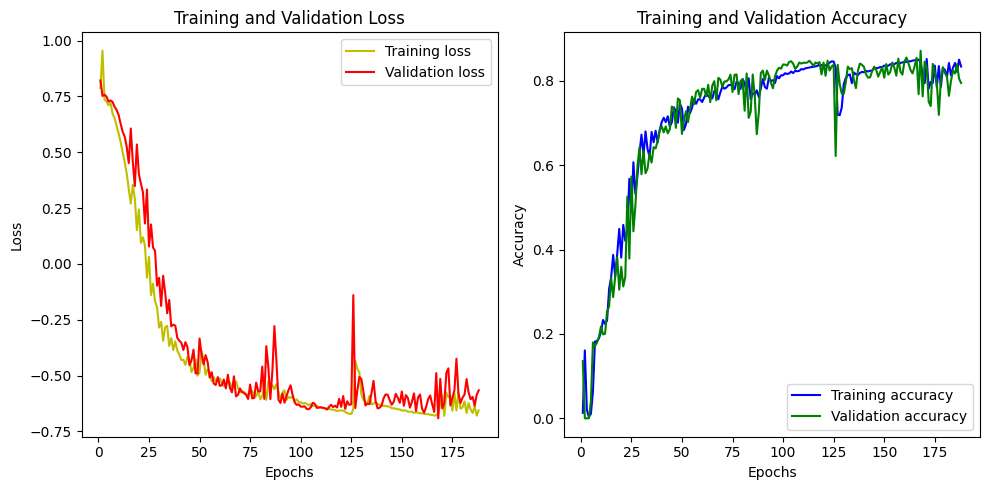

In [32]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, loss[:-20], 'y', label='Training loss')
plt.plot(epochs, val_loss[:-20], 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, iou_score[:-20], 'b', label='Training accuracy')
plt.plot(epochs, val_iou_score[:-20], 'g', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### Result Visualization

In [33]:
def preprocessInputImage(input_img):
    X_size = 128
    y_size = 128
    image = []
    input_img = cv2.resize(input_img, (y_size, X_size))
    image.append(input_img)          
    image = np.array(image)
    image = image / 255
    return image

In [34]:
def feedInput2Model(model_input_image):
    prediction = (model.predict(model_input_image))
    prediction_image = np.argmax(prediction, axis=3)[0]
    return prediction_image

(3024, 3024, 3)
(3024, 3024)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
(128, 128)


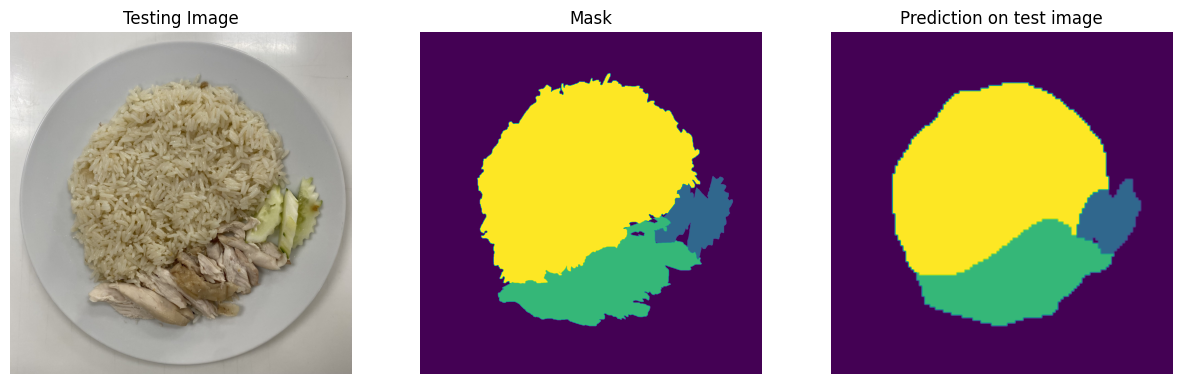

In [42]:
index = input('Image index: ')
if len(index) == 1:
    index = '0' + str(index)
input_img = cv2.imread(f'../Data/Images/3/I0{index}/0{index}-1.jpg', 1)
input_mask = cv2.imread(f'../Data/Masks/3/L0{index}/L0{index}-1.png', 0)
input_img_plot = cv2.cvtColor(input_img, cv2.COLOR_BGR2RGB)
print(input_img.shape)
print(input_mask.shape)
prediction_image = feedInput2Model(preprocessInputImage(input_img))
print(prediction_image.shape)

plt.figure(figsize=(15, 10))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(input_img_plot)
plt.axis('off')

plt.subplot(232)
plt.title('Mask')
plt.imshow(input_mask)
plt.axis('off')

plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction_image)
plt.axis('off')
plt.show()

In [43]:
def calculateProportion(mask):
    segment_areas = {}
    segment = [1, 2, 3]
    categories = ['Vegetable', 'Protein', 'Carbohydrate']

    for label in segment:
        area = np.sum(mask == label)
        segment_areas[label] = area

    
    segment_areas = {key: segment_areas[key] for key in segment}

    total_area = sum(segment_areas.values())

    for label, area in segment_areas.items():
        proportion = area / total_area
        print(f'{categories[label-1]} Proportion = {proportion:.4f}')

In [45]:
print('Actual proportion:')
calculateProportion(input_mask)

print('\nPrediction proportion:')
calculateProportion(prediction_image)

Actual proportion:
Vegetable Proportion = 0.0746
Protein Proportion = 0.2293
Carbohydrate Proportion = 0.6961

Prediction proportion:
Vegetable Proportion = 0.0696
Protein Proportion = 0.2598
Carbohydrate Proportion = 0.6706
